# Block Ciphers

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import cm
from random import getrandbits
from time import time
from Crypto.Cipher import AES

sns.set_style('darkgrid')
# Setting default figure size and dpi for matplotlib plots
plt.rc('figure', figsize=(10, 6), dpi=200)

def pad(x):
    # Pad the input bytes to ensure the length is a multiple of the block size
    return x + b'\0' * (AES.block_size - len(x) % AES.block_size)

def strip(x):
    # Remove padding from decrypted data
    return x.rstrip(b'\0')

def hexdump(x):
    # Convert bytes to hexadecimal representation
    return ' '.join(f'{b:02X}' for b in x)

def flatten(xss):
    # Flatten a list of lists into a single list
    return [x for xs in xss for x in xs]

def cipher_params(cipher, mode):
    if mode in [AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CFB]:
        return dict(iv=cipher.iv)
    if mode in [AES.MODE_CTR]:
        return dict(nonce=cipher.nonce)
    return {}

In [8]:
import os

modenames = ['ECB', 'CBC', 'OFB', 'CTR', 'CFB']
files = ['1MB.jpg', '7MB.mp4', '10MB.mp4']

# Get sizes of the files and store them in the sizes list
sizes = []
for file in files:
    size = os.path.getsize(file) / (1024 * 1024)  # Convert bytes to megabytes
    sizes.append(size)

# Print the sizes of the files in MB
for file, size in zip(files, sizes):
    print(f"Size of {file}: {size:.2f} MB")

modes = [AES.MODE_ECB, AES.MODE_CBC, AES.MODE_OFB, AES.MODE_CTR, AES.MODE_CFB]
key = getrandbits(16*8).to_bytes(16, byteorder='little')

decr_time = pd.DataFrame(index=files, columns=modenames)
encr_time = pd.DataFrame(index=files, columns=modenames)

print('key =', hexdump(key))


Size of 1MB.jpg: 1.01 MB
Size of 7MB.mp4: 7.00 MB
Size of 10MB.mp4: 10.00 MB
key = D8 A1 0D B6 0A 2A 23 19 46 42 B0 4F CA 03 C6 AA


## Encryption and decryption time analysis

In [17]:
for file in files:
    with open(file, 'rb') as f:
        original = f.read()
        
    # Loop through each encryption mode and corresponding mode name
    for mode, name in zip(modes, modenames):
        # Create a new AES cipher object
        c1 = AES.new(key, mode)
        t1 = time()
        # Padding
        encrypted = c1.encrypt(pad(original))
        t1 = time() - t1
        
        # Create a new AES cipher object for decryption
        c2 = AES.new(key, mode, **cipher_params(c1, mode))
        t2 = time()
        decrypted = c2.decrypt(encrypted)
        # Calculate decryption time
        t2 = time() - t2
        decrypted = strip(decrypted)
        
        # Store encryption and decryption times in DataFrames
        # Use precision of nanoseconds (1e-9 seconds)
        encr_time.loc[file, name] = round(t1, 9)
        decr_time.loc[file, name] = round(t2, 9)


In [19]:
def join_frames(a, b):
    # Concatenate the two DataFrames side by side along the columns axis
    df = pd.concat([a, b], axis=1)
    # Rename the columns to distinguish between encryption and decryption times
    df.columns = [x+' - encrypt' for x in modenames] + [x+' - decrypt' for x in modenames]
    
    # Return the joined DataFrame with specified column order
    return df[flatten([(x+' - encrypt', x+' - decrypt') for x in modenames])]

time_all = join_frames(encr_time, decr_time)
time_all

,ECB - encrypt,ECB - decrypt,CBC - encrypt,CBC - decrypt,OFB - encrypt,OFB - decrypt,CTR - encrypt,CTR - decrypt,CFB - encrypt,CFB - decrypt
1MB.jpg,0.0,0.004963,0.008017,0.009031,0.008003,0.00362,0.0,0.0,0.065389,0.042876
7MB.mp4,0.022962,0.015624,0.032413,0.01561,0.038081,0.031245,0.031241,0.0,0.339176,0.283632
10MB.mp4,0.015626,0.015621,0.035986,0.015659,0.037325,0.046868,0.028469,0.015623,0.454161,0.369605


In [27]:
def join_frames_and_speed_ratio(encr_time, decr_time):
    # Replace zeros with a very small number to avoid division by zero
    encr_time.replace(0, 1e-10, inplace=True)
    # Initialize an empty DataFrame to store the speed ratios
    speed_ratio = pd.DataFrame()
    
    # Loop through each mode
    for mode in modenames:
        # Calculate the quotient of speeds for the current mode
        ratio = decr_time[mode] / encr_time[mode]
        # Rename the column for clarity
        ratio.name = f"{mode}"
        # Append the speed ratio for the current mode to the DataFrame
        speed_ratio = pd.concat([speed_ratio, ratio], axis=1)
    
    return speed_ratio

# Call the function to generate the table containing the quotient of speeds
time_all_with_speed_ratio = join_frames_and_speed_ratio(encr_time, decr_time)

print("encryption time / decryption time")
time_all_with_speed_ratio



encryption time / decryption time


,ECB,CBC,OFB,CTR,CFB
1MB.jpg,49631600.0,1.126576,0.452316,0.0,0.6557
7MB.mp4,0.680428,0.481607,0.820477,0.0,0.83624
10MB.mp4,0.99971,0.435148,1.255669,0.548762,0.813818


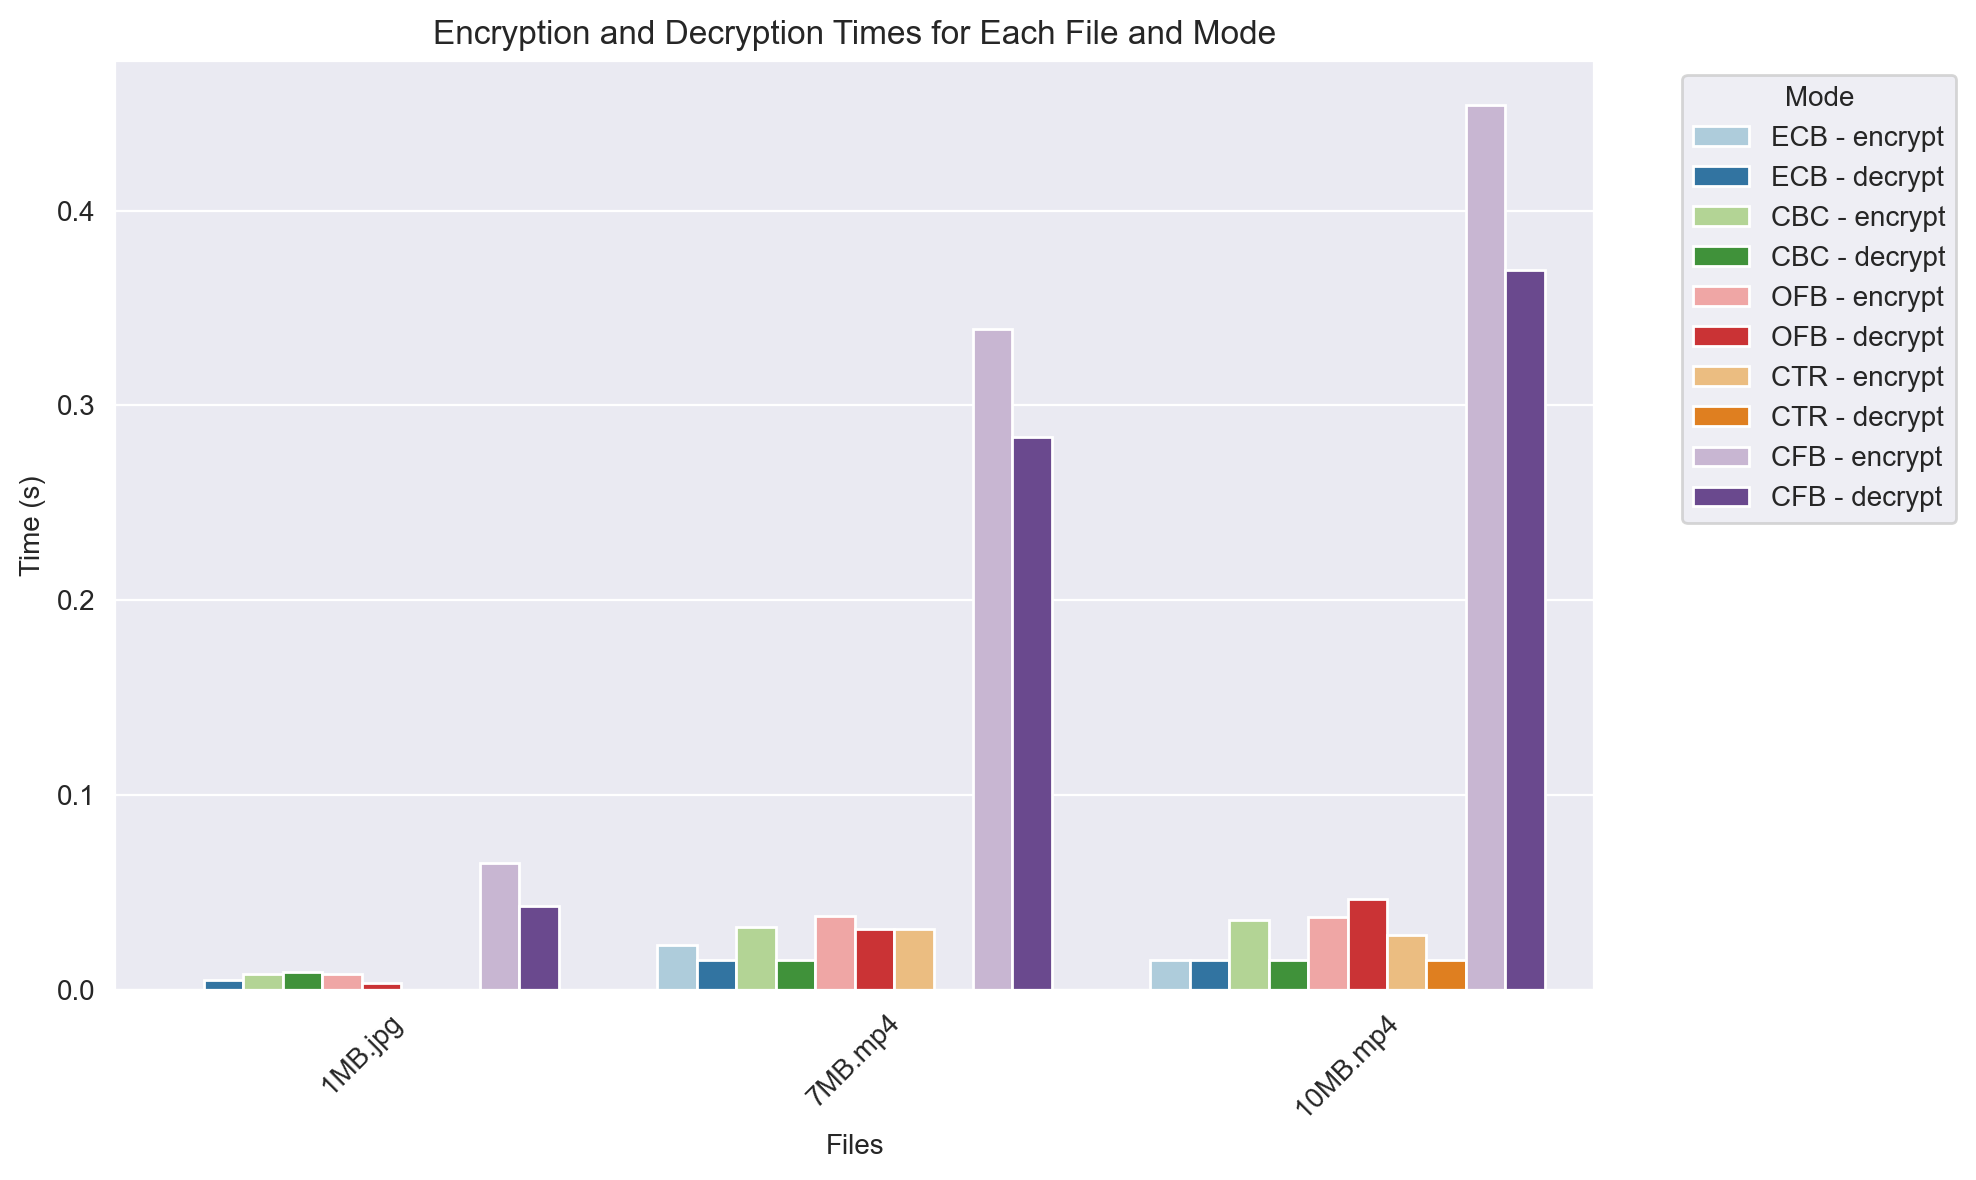

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Transpose the DataFrame so that files are rows and modes are columns
time_all_transposed = time_all.T

# Reset index to convert the modes into a column
time_all_transposed = time_all_transposed.reset_index()

# Melt the DataFrame to have a single 'time' column
time_all_melted = pd.melt(time_all_transposed, id_vars='index', var_name='File', value_name='Time')

# Plot the data
plt.figure(figsize=(10, 6))
sns.barplot(data=time_all_melted, x='File', y='Time', hue='index', palette='Paired')

# Set labels and title
plt.xlabel('Files')
plt.ylabel('Time (s)')
plt.title('Encryption and Decryption Times for Each File and Mode')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show legend
plt.legend(title='Mode', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.tight_layout()
plt.show()


## Error propagation analysis

In [37]:
text = b'Cats are wonderful creatures. They are cute, playful, and independent. Cats have a special charm that can brighten up anyone\'s day. They are great companions and provide comfort and joy to their owners. Whether they are lounging in the sun or chasing after a toy, cats always manage to bring a smile to our faces.'

print('--- ORIGINAL ---')
print(text.decode('latin-1'))
print()

for mode, name in zip(modes, modenames):
    # Create a new AES cipher object for encryption
    c1 = AES.new(key, mode)
    encrypted = c1.encrypt(pad(text))
    
    # Introduce an intentional error in the encrypted text (for demonstration purposes)
    encrypted = bytearray(encrypted)
    encrypted[120] = 0

    # Create a new AES cipher object for decryption
    c2 = AES.new(key, mode, **cipher_params(c1, mode))
    decrypted = strip(c2.decrypt(encrypted))
    
    print('---', name, '---')
    print(decrypted.decode('latin-1'))
    print()


--- ORIGINAL ---
Cats are wonderful creatures. They are cute, playful, and independent. Cats have a special charm that can brighten up anyone's day. They are great companions and provide comfort and joy to their owners. Whether they are lounging in the sun or chasing after a toy, cats always manage to bring a smile to our faces.

--- ECB ---
Cats are wonderful creatures. They are cute, playful, and independent. Cats have a special charm that can brigho¤u<õTÆ,¶ay. They are great companions and provide comfort and joy to their owners. Whether they are lounging in the sun or chasing after a toy, cats always manage to bring a smile to our faces.

--- CBC ---
Cats are wonderful creatures. They are cute, playful, and independent. Cats have a special charm that can brightÇÍuO+ü~¥2Aú*ìay. TheyÏare great companions and provide comfort and joy to their owners. Whether they are lounging in the sun or chasing after a toy, cats always manage to bring a smile to our faces.

--- OFB ---
Cats

## CBC mode

In [40]:
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad, unpad

def encrypt_cbc(plaintext, key, iv):
    cipher = AES.new(key, AES.MODE_ECB)
    ciphertext = b''
    previous_block = iv

    # Pad the plaintext to ensure each block is of size 16 bytes
    plaintext = pad(plaintext, AES.block_size)

    for i in range(0, len(plaintext), AES.block_size):
        block = plaintext[i:i+AES.block_size]
        # XOR plaintext block with previous ciphertext block (or IV for the first block)
        block = bytes(a ^ b for a, b in zip(block, previous_block))
        # Encrypt the XOR result using ECB mode
        encrypted_block = cipher.encrypt(block)
        ciphertext += encrypted_block
        # Update the previous block with the current ciphertext block
        previous_block = encrypted_block

    return ciphertext

def decrypt_cbc(ciphertext, key, iv):
    cipher = AES.new(key, AES.MODE_ECB)
    plaintext = b''
    previous_block = iv

    for i in range(0, len(ciphertext), AES.block_size):
        block = ciphertext[i:i+AES.block_size]
        # Decrypt ciphertext block using ECB mode
        decrypted_block = cipher.decrypt(block)
        # XOR decrypted block with previous ciphertext block (or IV for the first block)
        plaintext_block = bytes(a ^ b for a, b in zip(decrypted_block, previous_block))
        plaintext += plaintext_block
        # Update the previous block with the current ciphertext block
        previous_block = block

    # Unpad the plaintext to remove the padding added during encryption
    plaintext = unpad(plaintext, AES.block_size)

    return plaintext

# Example usage:
key = b'0123456789abcdef'  # 16 bytes (128 bits) key
iv = b'abcdefghijklmnop'   # 16 bytes (128 bits) IV

plaintext = b'This is a secret message'
ciphertext = encrypt_cbc(plaintext, key, iv)
print("Ciphertext (CBC):", ciphertext.hex())

decrypted_text = decrypt_cbc(ciphertext, key, iv)
print("Decrypted text:", decrypted_text.decode())


Ciphertext (CBC): 1b804dd515570108e811d91356202f27d6d2e08583839720a6de7e4aeaed9121
Decrypted text: This is a secret message
